# LLM Judgment - Human Judgment as a Target

This experiments applied the signed differecnes of LLM labels and human labels as a target for analysis the features.

In [9]:
import pandas as pd
import glob
import statsmodels.api as sm
import numpy as np
import statsmodels.formula.api as smf

### Plots for Model Assumptions

In [10]:
## Function to check model assumptions 
import matplotlib.pyplot as plt
import scipy.stats as stats
import matplotlib.pyplot as plt

def plot_residuals(result):
    
    # Extract residuals and fitted values
    residuals = result.resid
    fitted_values = result.fittedvalues

    # Q-Q plot
    plt.figure(figsize=(8, 6))
    stats.probplot(residuals, dist="norm", plot=plt)
    plt.title('Q-Q Plot')
    plt.show()

    # Histogram of residuals
    plt.figure(figsize=(8, 6))
    plt.hist(residuals, bins=30, edgecolor='k')
    plt.title('Histogram of Residuals')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.show()

    # Residuals vs. Fitted values
    plt.figure(figsize=(8, 6))
    plt.scatter(fitted_values, residuals, alpha=0.5)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel('Fitted Values')
    plt.ylabel('Residuals')
    plt.title('Residuals vs Fitted Values')
    plt.show()

### Plot for Coefficients

In [11]:
def plot_coef(result):
    
    # Step 1: Extract the coefficients and p-values
    coefficients = result.params
    p_values = result.pvalues

    print("Coefficients from the model:")
    print("P-values from the model:")

    # Step 2: Plot the coefficients with p-values
    # Convert coefficients and p-values to a DataFrame for easy plotting
    coeff_df = pd.DataFrame({
        'coefficients': coefficients,
        'p_values': p_values,
        'features': coefficients.index
    })

    # Create the bar plot
    plt.figure(figsize=(8, 5))
    bars = plt.barh(coeff_df['features'], coeff_df['coefficients'], color='skyblue')

    # Add the p-values as text annotations next to each bar
    for bar, p_value in zip(bars, coeff_df['p_values']):
        plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'p = {p_value:.3f}', 
                va='center', ha='left', fontsize=10)

    # Add titles and labels
    plt.title('Extracted Coefficients with P-Values from the Model')
    plt.xlabel('Coefficient Value')
    plt.ylabel('Features')
    plt.grid(True)

    # Display the plot
    plt.show()

### Data

In [12]:
results_from = "LLMJudge2024"

In [13]:
def get_trec_qrels():
    # Load each text file into a DataFrame
    qrel_human_df = pd.read_csv('./qrels/2023.qrels.pass.withDupes.txt', delimiter=' ', header=None, names=['qid', 'Q0', 'docid', 'label'])  # adjust delimiter if necessary
    qrel_llm_df = pd.read_csv('./qrels/2023.qrels.pass.gpt4.txt', delimiter=' ', header=None, names=['qid', 'Q0', 'docid', 'label'])

    # Merge the two DataFrames based on a common column, e.g., 'id'
    qrels_df = pd.merge(qrel_human_df, qrel_llm_df, on=['qid', 'docid'])

    qrels_df.drop(['Q0_x'], axis=1, inplace=True)
    qrels_df.drop(['Q0_y'], axis=1, inplace=True)

    qrels_df.rename(columns={'label_x': 'label_human'}, inplace=True)
    qrels_df.rename(columns={'label_y': 'label_llm'}, inplace=True)

    qrels_df['llm_human_diff'] = qrels_df['label_llm'] - qrels_df['label_human']

    # Display or save the merged DataFrame
    # print(qrels_df['llm-human'])

In [14]:
qrels = glob.glob(f'./qrels/{results_from}/*.txt')

In [15]:
for removed_labler in ['TREMA-rubric0', 'RMITIR-llama70B', 'llmjudge-thomas3', 'Olz-exp', 'llmjudge-simple3', 'NISTRetrieval-instruct0', 'TREMA-4prompts']:
    removed_labler = f'./qrels/{results_from}/{removed_labler}.txt'
    qrels.remove(removed_labler)

In [18]:
qrels_df_list = []

for infile in qrels:
    judger = infile.split('/')[3]
    result_df = pd.read_csv(infile, sep=' ', header=None, names=['qid', 'Q0', 'docid', 'score'])
    result_df.drop(['Q0'], axis=1, inplace=True)
    result_df['judged_by'] = judger
    result_df['qid'] = result_df['qid'].astype(int)
    result_df['score'] = result_df['score'].astype(int)
    qrels_df_list.append(result_df)
 
qrels_df = pd.concat(qrels_df_list)
qrels_df

,qid,docid,score,judged_by
0,2002168,msmarco_passage_00_662986293,3,llmjudge.qrels.nist.txt
1,2002168,msmarco_passage_00_662987062,3,llmjudge.qrels.nist.txt
2,2002168,msmarco_passage_00_662989674,1,llmjudge.qrels.nist.txt
3,2002168,msmarco_passage_01_366786438,3,llmjudge.qrels.nist.txt
4,2002168,msmarco_passage_01_366787276,2,llmjudge.qrels.nist.txt
...,...,...,...,...
4418,3100825,msmarco_passage_67_786441513,3,TREMA-direct.txt
4419,3100825,msmarco_passage_67_797018148,3,TREMA-direct.txt
4420,3100825,msmarco_passage_68_250089795,2,TREMA-direct.txt
4421,3100825,msmarco_passage_68_682638740,3,TREMA-direct.txt


In [20]:
qrels_df['judged_by'].unique()

array(['llmjudge.qrels.nist.txt', 'Olz-gpt4o.txt', 'TREMA-direct.txt'],
      dtype=object)

In [21]:
qrels_df['judged_by'] = qrels_df['judged_by'].replace({'llmjudge.qrels.nist.txt': 'Human', 'Olz-gpt4o.txt': 'GPT-4', 'TREMA-direct.txt': 'FlanT5'})

In [22]:
qrels_df

,qid,docid,score,judged_by
0,2002168,msmarco_passage_00_662986293,3,Human
1,2002168,msmarco_passage_00_662987062,3,Human
2,2002168,msmarco_passage_00_662989674,1,Human
3,2002168,msmarco_passage_01_366786438,3,Human
4,2002168,msmarco_passage_01_366787276,2,Human
...,...,...,...,...
4418,3100825,msmarco_passage_67_786441513,3,FlanT5
4419,3100825,msmarco_passage_67_797018148,3,FlanT5
4420,3100825,msmarco_passage_68_250089795,2,FlanT5
4421,3100825,msmarco_passage_68_682638740,3,FlanT5


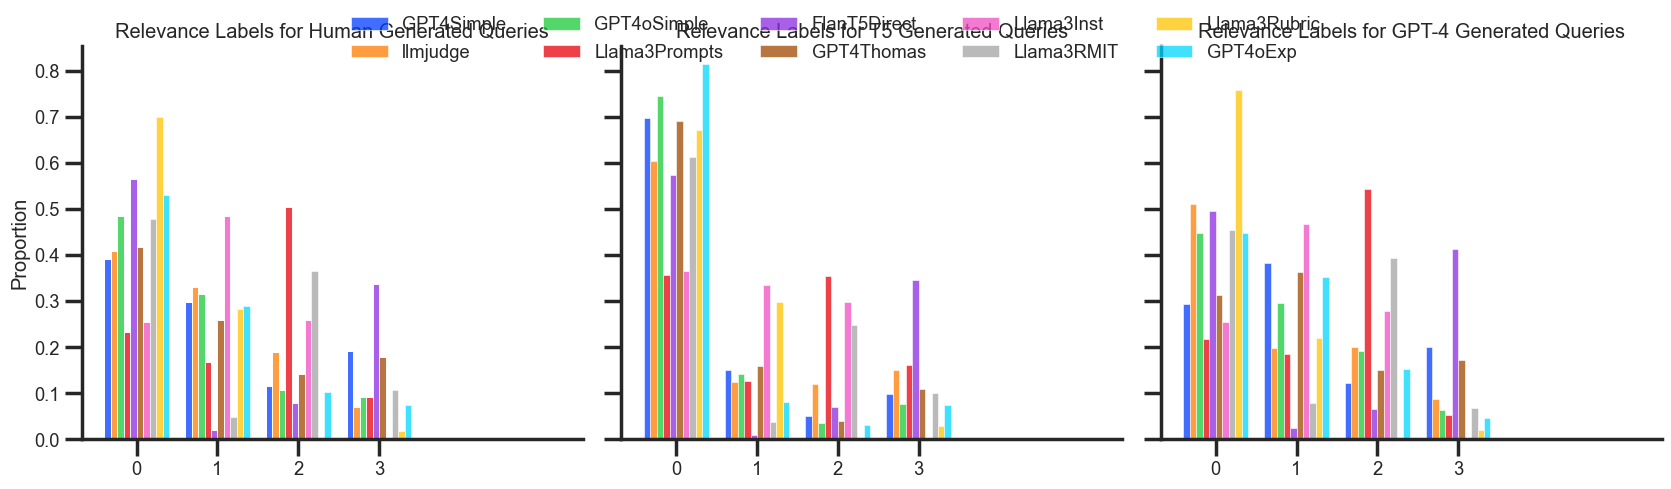

In [29]:
import seaborn as sns

df = data

df['score'] = df['score'].astype('category')



sns.set_style("ticks")  # Options: white, dark, whitegrid, darkgrid, ticks
sns.set_context("poster", font_scale =0.6)     # Options: paper, notebook, talk, poster
sns.set_palette("bright")   # You can also use: deep, muted, bright, dark, colorblind, or a custom list of colors

# Create a FacetGrid for the label type
g = sns.FacetGrid(df, col="QT", hue="judged_by", height=5)

# Add a histogram to the FacetGrid
g.map(sns.histplot, 'score', stat="proportion", hue = 'judged_by', multiple='dodge', shrink = .8, common_norm=False, data = df)

# Adjust the titles and labels
g.add_legend()
g.set_axis_labels("", "Proportion")
g.set_titles(col_template="{col_name}")

titles = ['Relevance Labels for Human Generated Queries', 'Relevance Labels for T5 Generated Queries', 'Relevance Labels for GPT-4 Generated Queries']

for ax, title in zip(g.axes.flatten(),titles):
    ax.set_title(title)
    
sns.move_legend(g, ncol=5, loc='upper center', title = '')

# Adjust layout
plt.subplots_adjust(top=0.85)

# Show the plot
plt.xticks([0, 1, 2, 3])  # Set y-ticks to 0, 1, 2, 3
plt.tight_layout()
plt.show()

### Modelling LLM Label 

In [13]:
mixed_model_1 = "label_llm ~ label_human * (QL + QW + PW + QT)"
mixed_model = "llm_human_diff ~ QL + QW + QT+ PW"
mixed_model_int = "llm_human_diff ~ QT * (QL + QW + PW)"

In [ ]:
model = sm.MixedLM.from_formula(mixed_model_1, data, groups=data["docid"])
result = model.fit()
result.summary()

In [ ]:
plot_coef(result)
plot_residuals(result)

In [ ]:
model = smf.glm(formula=mixed_model_1, data=data, family=sm.families.Poisson())
result = model.fit()
result.summary()

In [ ]:
plot_coef(result)

In [ ]:
data_log = data.copy()

data_log['label_llm'] = np.log(data_log['label_llm'])
model = model = sm.MixedLM.from_formula(mixed_model_1, data, groups=data_log["docid"])

result = model.fit()
result.summary()

In [ ]:
data_cat = data.copy()

data_cat = pd.melt(data_cat, value_vars = ['label_human', 'label_llm'], 
                   id_vars = ['QL',
       'QDR', 'QDS', 'QW', 'PW', 'QT', 'qid', 'docid'],
              var_name = 'label_type', value_name = 'label')


print(data_cat)

mixed_model = "label ~ label_type * (QW + PW + QT)"


model = sm.MixedLM.from_formula(mixed_model, data_cat, groups=data_cat["docid"])
result = model.fit()
result.summary()

In [ ]:
df = data_cat[['label', 'label_type', 'QW', 'PW', 'QT']]
df['label'] = df['label'].astype('category')

import seaborn as sns


# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Create a FacetGrid for the label type
g = sns.FacetGrid(df, col="label_type", hue="QT", height=5)

# Add a histogram to the FacetGrid
g.map(sns.histplot, 'label', stat="count", hue = 'QT', multiple='dodge', shrink = .8, common_norm=False, data = df)

# Adjust the titles and labels
g.add_legend()
g.set_axis_labels("Relevance Label", "Count")
g.set_titles(col_template="{col_name}")

# Adjust layout
plt.subplots_adjust(top=0.85)
g.fig.suptitle('Distribution of Relevance Judgements by Label Type and Query Type')

# Show the plot
plt.xticks([0, 1, 2, 3])  # Set y-ticks to 0, 1, 2, 3
plt.show()

In [ ]:
df = data_cat[['label', 'label_type', 'QW', 'PW', 'QT']]
df['label'] = df['label'].astype('category')
df['QT'] = df['QT'].replace({0: 'Human generated Query', 1: 'T5 generated Query', 2: 'GPT-4 generated Query'})
df['label_type'] = df['label_type'].replace({'label_human': 'Human Generated Labels', 'label_llm':'GPT-4 Generated Labels'})


import seaborn as sns


sns.set_style("ticks")  # Options: white, dark, whitegrid, darkgrid, ticks
sns.set_context("poster", font_scale =0.6)     # Options: paper, notebook, talk, poster
sns.set_palette("bright")   # You can also use: deep, muted, bright, dark, colorblind, or a custom list of colors

# Create a FacetGrid for the label type
g = sns.FacetGrid(df, col="QT", hue="label_type", height=5)

# Add a histogram to the FacetGrid
g.map(sns.histplot, 'label', stat="proportion", hue = 'label_type', multiple='dodge', shrink = .8, common_norm=False, data = df)

# Adjust the titles and labels
g.add_legend()
g.set_axis_labels("", "Proportion")
g.set_titles(col_template="{col_name}")

titles = ['Relevance Labels for Human Generated Queries', 'Relevance Labels for T5 Generated Queries', 'Relevance Labels for GPT-4 Generated Queries']

for ax, title in zip(g.axes.flatten(),titles):
    ax.set_title(title)
    
sns.move_legend(g, ncol=3, loc='upper center', title = '')

# Adjust layout
plt.subplots_adjust(top=0.85)

# Show the plot
plt.xticks([0, 1, 2, 3])  # Set y-ticks to 0, 1, 2, 3
plt.savefig("figs/label_barplots.pdf", bbox_inches="tight")
plt.show()


In [ ]:
import pandas as pd
from scipy.stats import chi2_contingency

# Contingency table
contingency_table = pd.crosstab(df['label'], df['label_type'])

# Chi-square test
chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f'Chi-square statistic: {chi2}, p-value: {p}')

In [ ]:
from scipy.stats import wilcoxon


# Perform Wilcoxon Signed-Rank Test (one-sided, alternative that GPT-4 labels are greater, null that GPT-4 labels are smaller than or equal to human)
stat, p_value = wilcoxon(data['label_human'], data['label_llm'], alternative='less')
print(f"Wilcoxon Signed-Rank statistic: {stat}, p-value: {p_value}")

stat, p_value = wilcoxon(data['llm_human_diff'], alternative='greater')
print(f"Wilcoxon Signed-Rank statistic: {stat}, p-value: {p_value}")

# Perform Wilcoxon Signed-Rank Test (one-sided, alternative that GPT-4 labels are smaller, null that GPT-4 labels are greater than or equal to human)
stat, p_value = wilcoxon(data['label_human'], data['label_llm'], alternative='greater')
print(f"Wilcoxon Signed-Rank statistic: {stat}, p-value: {p_value}")

stat, p_value = wilcoxon(data['llm_human_diff'], alternative='less')
print(f"Wilcoxon Signed-Rank statistic: {stat}, p-value: {p_value}")



# Perform Wilcoxon Signed-Rank Test (two-sided)
stat, p_value = wilcoxon(data['label_human'], data['label_llm'], alternative='two-sided')
print(f"Wilcoxon Signed-Rank statistic: {stat}, p-value: {p_value}")


In [ ]:
plot_coef(result)
plot_residuals(result)

In [ ]:
model = smf.glm(formula=mixed_model, data=data_cat, family=sm.families.Poisson())
result = model.fit()
result.summary()

In [ ]:
model = smf.glm(formula=mixed_model, data=data_cat, family=sm.families.NegativeBinomial())
result = model.fit()
result.summary()

In [ ]:
plot_coef(result)

In [ ]:
from statsmodels.miscmodels.ordinal_model import OrderedModel



# Fit ordinal logistic regression model
model = OrderedModel(data_cat['label'], exog, distr='logit')
result = model.fit(method='bfgs')

# Print the summary
print(result.summary())

In [ ]:
mixed_model_int = "score ~ isGPT4 + Judge + QL + QDR + QW + C(LLM, Treatment(reference='Other')) + C(Judge, Treatment(reference='nist')) * C(LLM, Treatment(reference='Other')) + isGPT4 * C(LLM, Treatment(reference='Other')) + pipeline"

In [ ]:
model = sm.MixedLM.from_formula(mixed_model_int, data, groups=data["run_id"])
result = model.fit()
result.summary()

In [ ]:
real_queries_real_judgments = data[((data['Judge'] == 'nist') & (data['qid'].isin(real_queries_judged)))]
synthetic_queries_real_judgments = data[((data['Judge'] == 'nist') & (data['qid'].isin(t5_queries_judged) | data['qid'].isin(gpt4_queries_judged)))]

In [ ]:
real_queries_synthetic_judgments = data[((data['Judge'] == 'gpt4') & (data['qid'].isin(real_queries_judged)))]
synthetic_queries_synthetic_judgments = data[((data['Judge'] == 'gpt4') & (data['qid'].isin(t5_queries_judged) | data['qid'].isin(gpt4_queries_judged)))]

In [ ]:
mixed_model_condition_Qreal = "score ~ QL + QDR + QW + C(LLM, Treatment(reference='Other')) + pipeline"
mixed_model_condition_Qsynthetic = "score ~ QL + QDS + QW + C(LLM, Treatment(reference='Other')) + pipeline"

In [ ]:
model = sm.MixedLM.from_formula(mixed_model_condition_Qreal, real_queries_real_judgments, groups=real_queries_real_judgments["run_id"])
result = model.fit()
result.summary()

In [ ]:
model = sm.MixedLM.from_formula(mixed_model_condition_Qsynthetic, synthetic_queries_real_judgments, groups=synthetic_queries_real_judgments["run_id"])
result = model.fit()
result.summary()

In [ ]:
model = sm.MixedLM.from_formula(mixed_model_condition_Qreal, real_queries_synthetic_judgments, groups=real_queries_synthetic_judgments["run_id"])
result = model.fit()
result.summary()

In [ ]:
model = sm.MixedLM.from_formula(mixed_model_condition_Qsynthetic, synthetic_queries_synthetic_judgments, groups=synthetic_queries_synthetic_judgments["run_id"])
result = model.fit()
result.summary()

In [ ]:
# Merging the dataframes on 'run_id' and 'qid'
real_queries_diff = pd.merge(real_queries_real_judgments, real_queries_synthetic_judgments[['run_id', 'qid', 'score']], on=['run_id', 'qid'], suffixes=('_a', '_b'))
# Subtracting the 'Score' values
real_queries_diff['score_ab'] = real_queries_diff['score_a'] - real_queries_diff['score_b']
real_queries_diff['score_ba'] = real_queries_diff['score_b'] - real_queries_diff['score_a']

In [ ]:
real_queries_diff

In [ ]:
model = sm.MixedLM.from_formula("score_ab ~ QL + QDR + QW + C(LLM, Treatment(reference='Other')) + pipeline", real_queries_diff, groups=real_queries_diff["run_id"])
result = model.fit()
result.summary()

In [ ]:
model = sm.MixedLM.from_formula("score_ba ~ QL + QDR + QW + C(LLM, Treatment(reference='Other')) + pipeline", real_queries_diff, groups=real_queries_diff["run_id"])
result = model.fit()
result.summary()

In [ ]:
# Merging the dataframes on 'run_id' and 'qid'
synthetic_queries_diff = pd.merge(synthetic_queries_real_judgments, synthetic_queries_synthetic_judgments[['run_id', 'qid', 'score']], on=['run_id', 'qid'], suffixes=('_a', '_b'))
# Subtracting the 'Score' values
synthetic_queries_diff['score_ab'] = synthetic_queries_diff['score_a'] - synthetic_queries_diff['score_b']
synthetic_queries_diff['score_ba'] = synthetic_queries_diff['score_b'] - synthetic_queries_diff['score_a']

In [ ]:
synthetic_queries_diff

In [ ]:
model = sm.MixedLM.from_formula("score_ab ~ QL + QDR + QW + C(LLM, Treatment(reference='Other')) + pipeline", synthetic_queries_diff, groups=synthetic_queries_diff["run_id"])
result = model.fit()
result.summary()

In [ ]:
model = sm.MixedLM.from_formula("score_ba ~ QL + QDR + QW + C(LLM, Treatment(reference='Other')) + pipeline", synthetic_queries_diff, groups=synthetic_queries_diff["run_id"])
result = model.fit()
result.summary()

## Extra Experiments (refer to: "Extra Exp. 1")

In [ ]:
def get_result(result_file):
    result_df = pd.read_csv(result_file, sep='\t', header=None, names=['run_id', 'metric', 'qid', 'score'])
    result_df = result_df[result_df['qid'] != 'all']
    result_df['score'] = result_df['score'].astype(float)
    result_df['qid'] = result_df['qid'].astype(int)
    result_df['metric'] = result_df['metric'].apply(lambda x: x.rstrip())
    result_df = result_df[(result_df['metric'] == metric)]
    result_df.drop(['metric'], axis=1, inplace=True)
    return result_df

In [ ]:
real_judge_results = get_result(result_file="results/all.pass.nist.ndcgeval")
synthetic_judge_results = get_result(result_file="results/all.pass.gpt4.ndcgeval")

In [ ]:
# Merging the dataframes on 'run_id' and 'qid'
results_diff = pd.merge(real_judge_results, synthetic_judge_results, on=['run_id', 'qid'], suffixes=('_real', '_synthetic'))
# Subtracting the 'Score' values
results_diff['score_RS'] = results_diff['score_real'] - results_diff['score_synthetic']
results_diff['score_SR'] = results_diff['score_synthetic'] - results_diff['score_real']

In [ ]:
results_diff = pd.merge(results_diff, qid_to_info, on='qid')
results_diff = pd.merge(results_diff, model_to_info, on='run_id')

In [ ]:
results_diff

Selected: score_SR

In [ ]:
results_diff['qd_RS'] = results_diff['QDR'] - results_diff['QDS']
results_diff['qd_SR'] = results_diff['QDS'] - results_diff['QDR']

In [ ]:
mixed_model_1 = "score_SR ~ Synthetic + QL + qd_SR + QW + DL + pipeline + C(LLM, Treatment(reference='Other')) + Synthetic * C(LLM, Treatment(reference='Other'))"

In [ ]:
model = sm.MixedLM.from_formula(mixed_model_1, results_diff, groups=results_diff["run_id"])
result = model.fit()
result.summary()